In [1]:
!nvidia-smi

Mon Nov 11 05:00:16 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   59C    P0             36W /   80W |     379MiB /   8192MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#%pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12
#%pip install cucim-cu12 cupy-cuda12x

In [3]:
#%load_ext cudf.pandas

#from cucim.skimage.exposure import rescale_intensity
import tensorflow as tf
#import cupy as cp
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import glob

print("Is torch using cuda? ",torch.cuda.is_available())
print("Is tensorflow using cuda? ",tf.test.is_built_with_cuda())
print("Is pandas using cuda? ",pd)


2024-11-11 05:00:17.529390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-11 05:00:17.601618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-11 05:00:17.622531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-11 05:00:17.773560: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Is torch using cuda?  True
Is tensorflow using cuda?  True
Is pandas using cuda?  <module 'pandas' from '/usr/local/lib/python3.11/dist-packages/pandas/__init__.py'>


In [4]:
name_mapping = [
    "box",
    "circularTorus",
    "cone",
    "coneOffset",
    "cylinder",
    "cylinderSlope",
    "dish",
    "mesh",
    "pyramid",
    "rectangularTorus",
    "sphere"
]

In [5]:
def sort_by_number(texts:list[str]):
    def key(text:str):
        text = re.sub(r'.*photos_', '', text)
        text = re.sub(r'\.csv', '', text)
        text = re.sub(r'\D', '', text)
        return int(text)
    return sorted(texts, key=key)

In [7]:
base_path = '/home/workspace/geometry-classifier/data/'

csv_files = sort_by_number(glob.glob(base_path+'photos_v3/*.csv'))


predictions = []
# Batch processing and prediction
batch_size = 256
true_labels = []
ids = []

model = tf.keras.applications.ResNet152V2(weights='imagenet', input_shape=(224, 224, 3), include_top=True, classes=1000)

def current_chunk(df):
    labels = df['name'].values
    images = df.drop(columns=['name', 'id'])

    # Preprocess function (as before)
    def preprocess_cudf_df(images_df, labels, batch_size):
        # Convert images to numpy and reshape for model input
        df_np = images_df.values.reshape(-1, 224, 224, 1)
        df_rgb = np.repeat(df_np, 3, axis=-1)
        
        # Create batches
        num_samples = df_rgb.shape[0]
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            yield df_rgb[start:end], labels[start:end]

    for batch_images, batch_labels in preprocess_cudf_df(images, labels, batch_size):
        preds = model.predict(batch_images)
        predicted_classes = np.argmax(preds, axis=1)
        predictions.extend(predicted_classes)
        true_labels.extend(batch_labels)
    
    ids.extend(df['id'].values)


I0000 00:00:1731301250.066725      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731301250.125211      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731301250.125501      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731301250.127400      12 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

242745792/242745792 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [8]:
csv_files

['/home/workspace/geometry-classifier/data/photos_v3/photos_1.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_2.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_3.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_4.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_5.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_6.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_7.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_8.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_9.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_10.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_11.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_12.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_13.csv',
 '/home/workspace/geometry-classifier/data/photos_v3/photos_14.csv',
 '/home/workspace/geometry-classifier/data/

In [9]:
save_to_csv = base_path + 'predictions.csv'
def save_prediction():
    import os
    if os.path.exists(save_to_csv):
        file_open_mode = 'a+'
    else:
        file_open_mode = 'w+'
    with open(save_to_csv, file_open_mode) as f:
        if file_open_mode == 'w+':
            f.write('id,prediction,true\n')
        for (id, pred, true) in zip(ids, predictions, true_labels):
            f.write(f"{id},{pred},{true}\n")
        

In [10]:
import gc
# read chunk of 4 csv files at a time
for csv_file in csv_files:
    print(f"Processing file: {csv_file}")
    df = pd.read_csv(csv_file)
    current_chunk(df)
    save_prediction()
    del df
    gc.collect()

Processing file: /home/workspace/geometry-classifier/data/photos_v3/photos_1.csv


I0000 00:00:1731301300.500055      80 service.cc:146] XLA service 0x740bc01b76d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731301300.500086      80 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 with Max-Q Design, Compute Capability 7.5
2024-11-11 05:01:40.769627: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-11 05:01:42.701129: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

I0000 00:00:1731301308.852241      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
Processing file: /home/workspace/geometry-classifier/data/photos_v3/photos_2.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step
Processing file: /home/workspace/geometry-classifier/data/photos_v3/photos_3.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
Processing file: /home/workspace/geometry-classifier/data/photos_v3/photos_4.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step
Processing file: /home/workspace/geometry-classifier/data/photos_v3/photos_5.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
8/8 ━━━━━━━━

In [11]:
list(zip(predictions, true_labels))
# print the one with the highest occurence of the predictions for each class
from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return data.most_common(1)[0]

def most_common_per_class(predictions, true_labels):
    data = {}
    for i, name in enumerate(name_mapping):
        data[name] = most_common([pred for pred, true in zip(predictions, true_labels) if true == i])
    return data

most_common_per_class(predictions, true_labels)

{'box': (549, 34806),
 'circularTorus': (619, 13140),
 'cone': (722, 9175),
 'coneOffset': (619, 449),
 'cylinder': (722, 77343),
 'cylinderSlope': (549, 183),
 'dish': (722, 2925),
 'mesh': (681, 29613),
 'pyramid': (681, 1131),
 'rectangularTorus': (681, 785),
 'sphere': (722, 1669)}

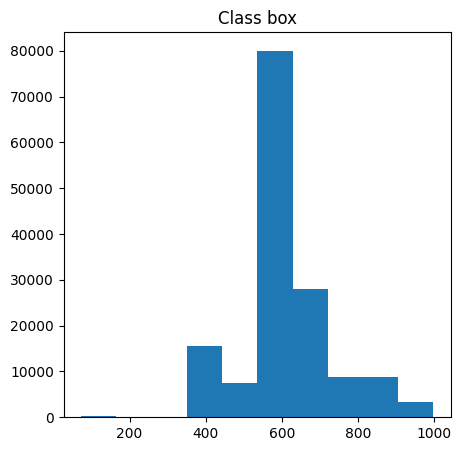

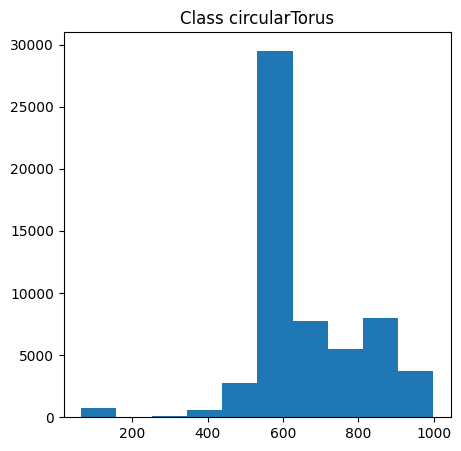

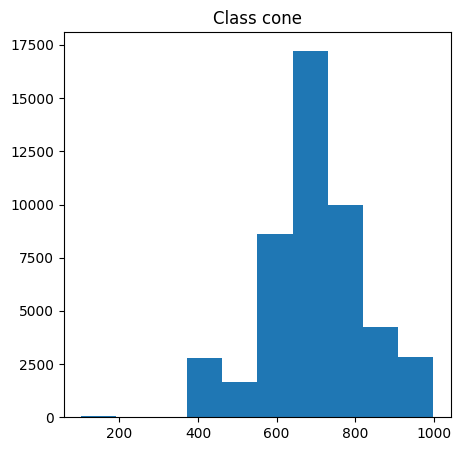

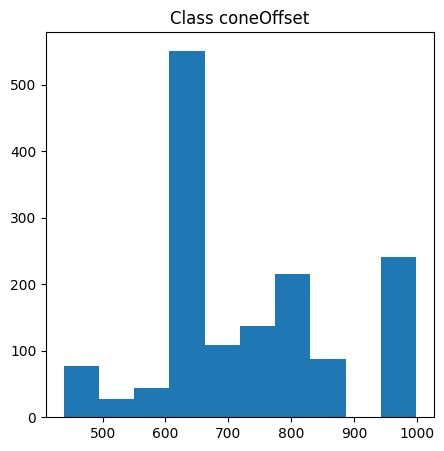

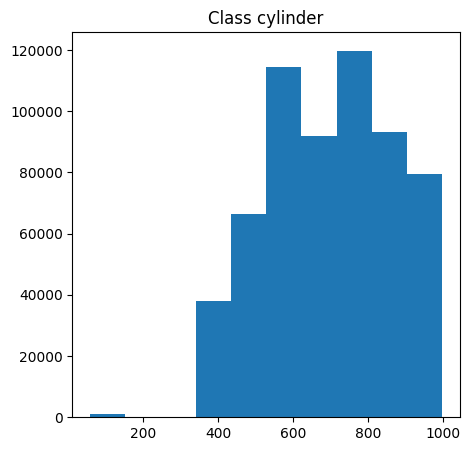

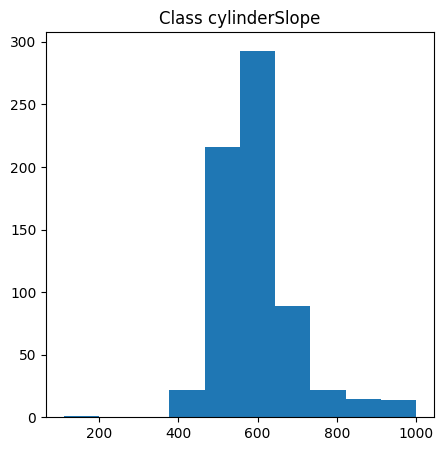

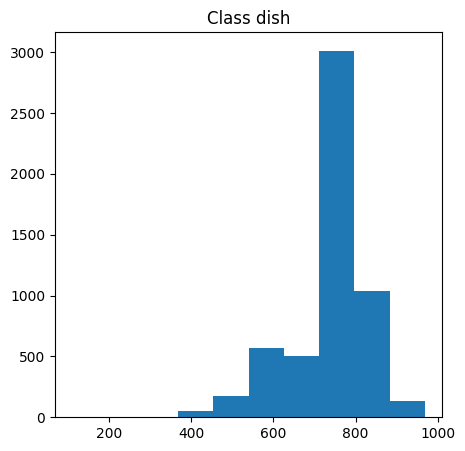

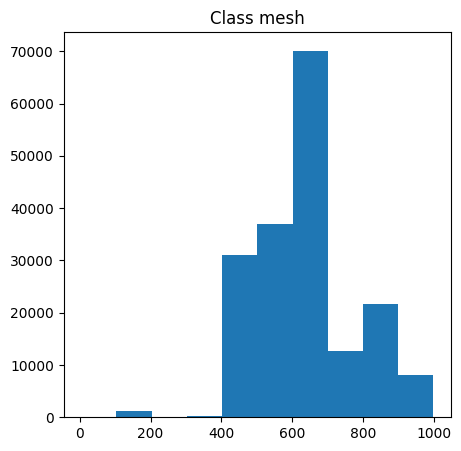

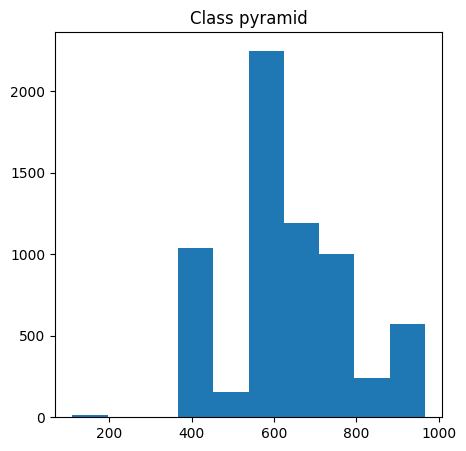

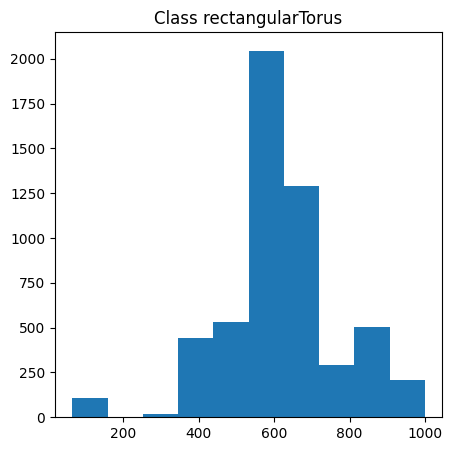

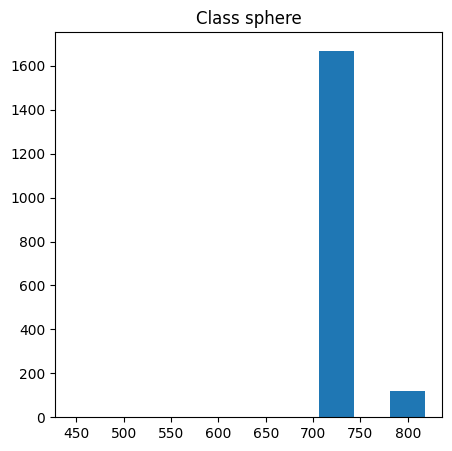

In [12]:
for i in range(len(name_mapping)):
    # get all the predictions for the class i
    class_i = [int(pred) for pred, t_label in zip(predictions, true_labels) if t_label == i]
    plt.figure(figsize=(5, 5))
    plt.title(f"Class {name_mapping[i]}")
    plt.hist(class_i)
    plt.show()

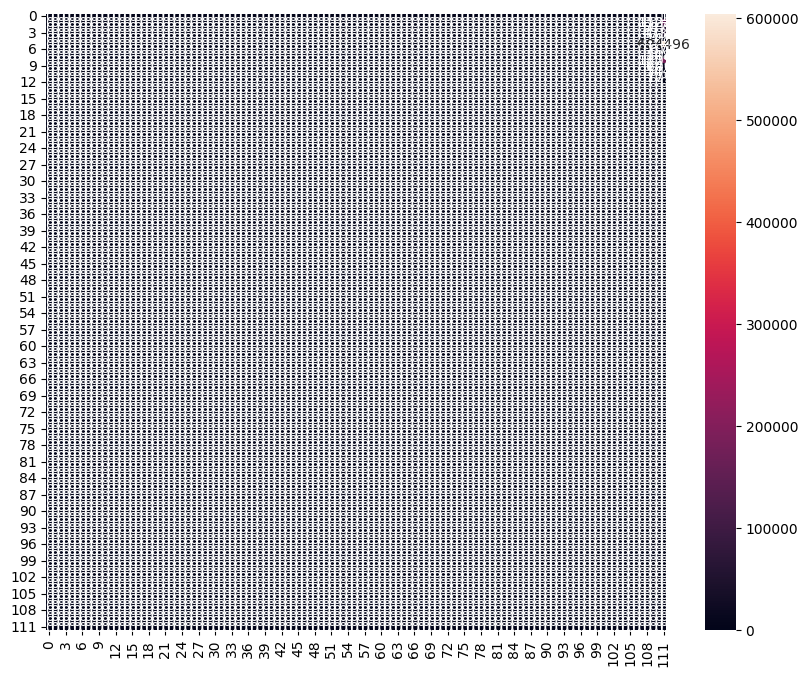

In [ ]:
# cofusion matrix
confusion_matrix = tf.math.confusion_matrix([t+1 for t in true_labels], predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()